The task we are going to perform is text classification (many-to-one).<br>
i.e. Input is sequence of words and Output is a single label<br>
<br>
#### Spam Detection <br>
For `torchtext`, at first, we want dataset to be a csv (1 column for label, 1 column for text).<br>
<br>
Next is torch Field objects.<br>
We need to create torch fiend objects for both input and output with different arguments for each.
<br>
<br>
Third step is to instantiate TabularDataset object.<br>
<br>
`build_vocab()` function assigns a unique integer to each unique token in the dataset.<br>
This function by itself doesnot returns anything<br>
But, after calling this function, we can access the vocab attribute which returns a vocab object.<br>
Vocab object contains word to index mapping.

## Load Data

In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

In [2]:
# Download the data
!wget -nc https://lazyprogrammer.me/course_files/spam.csv

--2023-06-16 16:48:36--  https://lazyprogrammer.me/course_files/spam.csv
Resolving lazyprogrammer.me (lazyprogrammer.me)... 172.67.213.166, 104.21.23.210, 2606:4700:3030::ac43:d5a6, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|172.67.213.166|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 503663 (492K) [text/csv]
Saving to: ‘spam.csv’

spam.csv            100%[===================>] 491.86K  1.81MB/s    in 0.3s    

2023-06-16 16:48:37 (1.81 MB/s) - ‘spam.csv’ saved [503663/503663]



In [3]:
# Bad formatting
!head spam.csv

v1,v2,,,
ham,"Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...",,,
ham,Ok lar... Joking wif u oni...,,,
spam,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's,,,
ham,U dun say so early hor... U c already then say...,,,
ham,"Nah I don't think he goes to usf, he lives around here though",,,
spam,"FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it still? Tb ok! XxX std chgs to send, �1.50 to rcv",,,
ham,Even my brother is not like to speak with me. They treat me like aids patent.,,,
ham,As per your request 'Melle Melle (Oru Minnaminunginte Nurungu Vettam)' has been set as your callertune for all Callers. Press *9 to copy your friends Callertune,,,
spam,WINNER!! As a valued network customer you have been selected to receivea �900 prize reward! To claim call 09061701461. Claim 

After taking a glance at the head of spam dataset, we can conclude that it <br>
is not encoded in `UTF-8` format. Instead it is encoded in `ISO-8859-1` format.

In [4]:
df = pd.read_csv('spam.csv', encoding = "ISO-8859-1")

In [5]:
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


Again, we can see that only data in first two columns are relevant and rest of the columns are basically empty.

In [6]:
# Drop unnecessary columns
df = df.drop(df.columns[[2, 3, 4]], axis = 1)

In [7]:
df.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [8]:
df.columns = ['labels', 'data']

In [9]:
df.head()

,labels,data
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [10]:
# Create binary labels
df['b_labels'] = df['labels'].map({'ham':0, 'spam':1})

In [11]:
df.head()

,labels,data,b_labels
0,ham,"Go until jurong point, crazy.. Available only ...",0
1,ham,Ok lar... Joking wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,ham,U dun say so early hor... U c already then say...,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",0


Split the data into test and train set

In [12]:
df_train, df_test = train_test_split(df, test_size = 0.33)

In [13]:
df_train.shape, df_test.shape

((3733, 3), (1839, 3))

## Generate Tokens

#### Generating tokens manually

In [14]:
# 0 = padding
idx = 1
word2idx = {'<PAD>':0}

In [15]:
for i, row in df_train.iterrows():

  tokens = row['data'].lower().split() # Simple Tokenization

  for token in tokens:
    if token not in word2idx:
      word2idx[token] = idx
      idx += 1

In [16]:
len(word2idx)

10568

#### Generating tokens using torchtext

## Data to word indices

In [17]:
train_sentences_as_int = []
for i, row in df_train.iterrows():
  tokens = row['data'].lower().split()
  sentences_as_int = [word2idx[token] for token in tokens]
  train_sentences_as_int.append(sentences_as_int)

In [18]:
test_sentences_as_int = []
for i, row in df_test.iterrows():
  tokens = row['data'].lower().split()
  sentences_as_int = [word2idx[token] for token in tokens if token in word2idx]
  test_sentences_as_int.append(sentences_as_int)

In [19]:
len(train_sentences_as_int), len(test_sentences_as_int)

(3733, 1839)

## Create data generators

In [20]:
def data_generator(X, y, batch_size = 32):

  X, y = shuffle(X, y)
  n_batches = int(np.ceil(len(y)/batch_size))

  for i in range(n_batches):
    end = min((i+1)* batch_size, len(y))

    X_batch = X[i * batch_size:end]
    y_batch = y[i * batch_size:end]

    # Pad X_batch to be N X T
    max_len = np.max([len(x) for x in X_batch])
    for j in range(len(X_batch)):
      x = X_batch[j]
      pad = [0] * (max_len - len(x))
      X_batch[j] = pad + x

    # Convert to tensor
    X_batch = torch.from_numpy(np.array(X_batch))
    y_batch = torch.from_numpy(np.array(y_batch))

    yield X_batch, y_batch

In [21]:
for inputs, targets in data_generator(train_sentences_as_int, df_train.b_labels):
  print(f"Inputs : {inputs}, shape : {inputs.shape}, Datatype: {type(inputs)}")
  print(f"Targets : {targets}, shape : {targets.shape}, Datatype: {type(targets)}")
  break

Inputs : tensor([[   0,    0,    0,  ..., 3874,  248, 8896],
        [   0,    0,    0,  ...,  340,   42,  680],
        [   0,    0,    0,  ...,   25,  181, 3655],
        ...,
        [   0,    0,    0,  ..., 2485,  181, 3556],
        [   0,    0,    0,  ...,  593,   99,   88],
        [   0,    0,    0,  ..., 2208,    6, 8564]]), shape : torch.Size([32, 56]), Datatype: <class 'torch.Tensor'>
Targets : tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
        0, 0, 1, 0, 0, 0, 0, 1]), shape : torch.Size([32]), Datatype: <class 'torch.Tensor'>


In [22]:
for inputs, targets in data_generator(test_sentences_as_int, df_test.b_labels):
  print(f"Inputs : {inputs}, shape : {inputs.shape}, Datatype: {type(inputs)}")
  print(f"Targets : {targets}, shape : {targets.shape}, Datatype: {type(targets)}")
  break

Inputs : tensor([[    0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,   159,   159,   836,   546,     4,   846,  2631],
        [    0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     1,  1937,   195,   199,
           333,  3297,   436,     1,  8418,  1312,   152,  3552],
        [   74,  1351,     6,   600,     1,  1352,   224,  1354,   121,   812,
          1355,   228,  1357,  1358,   511,  1195,  2121,  1160,  2245,  4491,
          2134,    42,  1364,    29,  1353,   295,  1871,  2051],
        [  475,   295,   696,  2030,  5280,  1640,   667,   136,    58,   461,
           705,   697,    30,   670,  1640,     6,   132,  1196,    39,   183,
            58,  8880,  5282,  1864,  5283,  5284,  1646,  5285],
        [    0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
           681, 

In [23]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [24]:
# Define the model
class RNN(nn.Module):
  def __init__(self, n_vocab, embed_dim, n_hidden, n_rnnlayers, n_outputs):
    super(RNN, self).__init__()
    self.V = n_vocab
    self.D = embed_dim
    self.M = n_hidden
    self.K = n_outputs
    self.L = n_rnnlayers

    self.embed = nn.Embedding(self.V, self.D)
    self.rnn = nn.LSTM(
        input_size = self.D,
        hidden_size = self.M,
        num_layers = self.L,
        batch_first = True
    )
    self.fc = nn.Linear(self.M, self.K)


  def forward(self, X):

    h0 = torch.zeros(self.L, X.size(0), self.M).to(device)
    c0 = torch.zeros(self.L, X.size(0), self.M).to(device)

    # Embedding layer
    out = self.embed(X)

    # LSTM output
    out, _ = self.rnn(out, (h0, c0))

    # Max pool
    out, _ = torch.max(out, 1)

    # Final layer
    out = self.fc(out)
    return out

In [25]:
model = RNN(len(word2idx), 20, 15, 1, 1)
model.to(device)

RNN(
  (embed): Embedding(10568, 20)
  (rnn): LSTM(20, 15, batch_first=True)
  (fc): Linear(in_features=15, out_features=1, bias=True)
)

In [26]:
# Loss and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters())

In [27]:
train_gen = lambda: data_generator(train_sentences_as_int, df_train.b_labels)
test_gen = lambda: data_generator(test_sentences_as_int, df_test.b_labels)

In [28]:
def train(model, criterion, optimizer, epochs):
  train_losses = np.zeros(epochs)
  test_losses = np.zeros(epochs)

  train_loss_average = None
  test_loss_average = None

  for it in range(epochs):
    t0 = datetime.now()
    train_loss = []

    for inputs, targets in train_gen():

      targets = targets.view(-1, 1)
      inputs, targets = inputs.to(device), targets.to(device)

      optimizer.zero_grad()

      outputs = model(inputs)
      loss = criterion(outputs, targets.float())

      loss.backward()
      optimizer.step()
      train_loss.append(loss)
    train_loss_average = torch.mean(torch.stack(train_loss))

    test_loss = []
    for inputs, targets in train_gen():

      inputs, targets = inputs.to(device), targets.to(device)
      targets = targets.view(-1, 1)
      outputs = model(inputs)
      loss = criterion(outputs, targets.float())
      test_loss.append(loss)
    test_loss_average = torch.mean(torch.stack(test_loss))

    train_losses[it] = train_loss_average
    test_losses[it] = test_loss_average

    dt = datetime.now() -t0
    print(f"End of Epoch {it + 1}/{epochs},------- Train Loss : {train_losses[it]:.4f}, Test Loss : {test_losses[it]:.4f}, Duration : {dt}")

  return train_losses, test_losses, train_loss, test_loss



In [29]:
train_losses, test_losses, train_loss, test_loss = train(model , criterion, optimizer, 15)

End of Epoch 1/15,------- Train Loss : 0.4370, Test Loss : 0.3781, Duration : 0:00:02.536101
End of Epoch 2/15,------- Train Loss : 0.3529, Test Loss : 0.3323, Duration : 0:00:02.249795
End of Epoch 3/15,------- Train Loss : 0.2932, Test Loss : 0.2553, Duration : 0:00:02.097682
End of Epoch 4/15,------- Train Loss : 0.2269, Test Loss : 0.1869, Duration : 0:00:02.848271
End of Epoch 5/15,------- Train Loss : 0.1642, Test Loss : 0.1396, Duration : 0:00:03.047379
End of Epoch 6/15,------- Train Loss : 0.1276, Test Loss : 0.1122, Duration : 0:00:01.541829
End of Epoch 7/15,------- Train Loss : 0.1013, Test Loss : 0.0891, Duration : 0:00:01.037999
End of Epoch 8/15,------- Train Loss : 0.0815, Test Loss : 0.0817, Duration : 0:00:01.041316
End of Epoch 9/15,------- Train Loss : 0.0688, Test Loss : 0.0631, Duration : 0:00:01.052108
End of Epoch 10/15,------- Train Loss : 0.0568, Test Loss : 0.0495, Duration : 0:00:01.048024
End of Epoch 11/15,------- Train Loss : 0.0484, Test Loss : 0.0415, D

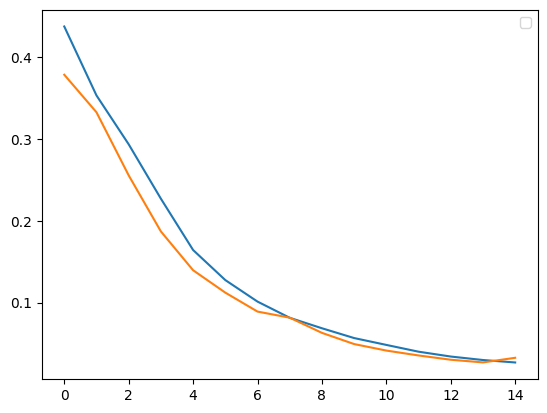

In [30]:
plt.plot(train_losses)
plt.plot(test_losses)
plt.legend()
plt.show()

In [31]:
# Calculate accuracy
n_correct = 0
n_total = 0

for inputs, targets in train_gen():
  targets = targets.view(-1, 1).float()
  inputs, targets = inputs.to(device), targets.to(device)

  # Forward pass
  outputs = model(inputs)

  # Get Predictions
  predictions = (outputs > 0)

  # update counts
  n_correct += (predictions == targets).sum()
  n_total =+ targets.shape[0]

train_acc = n_correct / 3733

n_correct = 0
n_total = 0
for inputs, targets in test_gen():
  targets = targets.view(-1, 1).float()
  inputs, targets = inputs.to(device), targets.to(device)

  # Forward pass
  outputs = model(inputs)

  # Get Predictions
  predictions = (outputs > 0)

  # update counts
  n_correct += (predictions == targets).sum()

  n_total =+ targets.shape[0]

test_acc = n_correct / 1839

In [32]:
train_acc

tensor(0.9933)

In [33]:
test_acc

tensor(0.9712)